### 1. GOAL

The goal of this task is to cluster search keywords semantically and do analysis related to other features : sales, order, etc. New approach are conducted in clustering process. We cluster the document instead of the vocabulary like we did previously. This make us easily do analysis between keywords and other features.

### 2. DATA

The data is from KW Clusters file https://docs.google.com/spreadsheets/d/1pDgWNNaEJqc7oNA8khVheK9uLX7Q6Bu-5L5BxBUoBJs/edit#gid=0 

### 3. TECHNIQUE SUMMARY

    3.1 Load data
    3.2 Tokenize and clean data
    3.3 Train word2vec on custom corpus
    3.4 Cluster keywords using K-Means
    3.5 Visualize clustering result
    3.6 Keywords analysis

### 3.1 Load Data

In [2]:
%matplotlib inline

import nltk.data;
from nltk.corpus import stopwords;
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string;

from gensim.models import Word2Vec;
from gensim.models.phrases import Phraser, Phrases;

from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import pandas as pd;
import numpy as np;
from statistics import mean

import os;
import re;
import logging;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;

In [4]:
# get keywords column from KW Clusters excel file
df = pd.read_excel('kw_clusters.xlsx', sheetname='All')

### 3.2 Tokenize and Clean Data

In [5]:
# tokenize keywords
df["tokenized_keywords"] = df["keywords"].apply(nltk.word_tokenize)

In [6]:
# convert dataframe to list of list
tokenized_keywords = df["tokenized_keywords"].values.tolist()

In [7]:
# Clean keywords
# Convert to lowercase
# Remove punctuation from each word
# Filter out remaining tokens that are not alphabetic
# Filter out tokens that are stop words
# lemmatization
def clean_text(list_tokens):
    #ps = PorterStemmer()
    word_lemma = WordNetLemmatizer()
    cleaned_tokens = list()
    for tokens in list_tokens:
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        #nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        # stemming
        # words = [ps.stem (w) for w in words]
        # lemmatize
        # nltk.download('wordnet')
        words = [word_lemma.lemmatize (w) for w in words]
        cleaned_tokens.append(words)
    return cleaned_tokens

In [8]:
# apply clean_text method to the tokenized_keywords
cleaned_keywords = clean_text(tokenized_keywords)

### 3.3 Train Word2Vec on Custom Corpus
We create Word2Vec model using our own data

In [9]:
start = time.time()

# set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# set values for various parameters
num_features = 50    # Dimensionality of the hidden layer representation
min_word_count = 25   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count()      # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       

# initialize and train the model
print("Training model...")
model = Word2Vec(cleaned_keywords, workers=num_workers, size=num_features, min_count = min_word_count, window = context)

# save the model
model_name = "model_keywords"
model.save(model_name)

print('Total time: ' + str((time.time() - start)) + ' secs')

2019-12-29 18:58:58,951 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-12-29 18:58:58,954 : INFO : collecting all words and their counts
2019-12-29 18:58:58,956 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-29 18:58:58,959 : INFO : collected 423 word types from a corpus of 4495 raw words and 288 sentences
2019-12-29 18:58:58,960 : INFO : Loading a fresh vocabulary
2019-12-29 18:58:58,962 : INFO : effective_min_count=25 retains 32 unique words (7% of original 423, drops 391)
2019-12-29 18:58:58,964 : INFO : effective_min_count=25 leaves 2701 word corpus (60% of original 4495, drops 1794)
2019-12-29 18:58:58,968 : INFO : deleting the raw counts dictionary of 423 items
2019-12-29 18:58:58,969 : INFO : sample=0.001 downsamples 32 most-common words
2019-12-29 18:58:58,970 : INFO : downsampling leaves estimated 542 word corpus (20.1% of prior 2701)
2019-12-29 18:58:58,972 : INFO : estimated required memory for 32 w

Training model...


C:\Users\user\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-12-29 18:58:59,148 : INFO : saved model_keywords


Total time: 0.20100641250610352 secs


In [10]:
# create average feature embedding for each sentence of keywords
def vectorizer(sentence, model_keywords):
    vec = list()
    num_keyword = 0
    for keyword in sentence:
        try:
            if num_keyword == 0:
                vec = model_keywords.wv[keyword]
            else:
                vec = np.add(vec, model_keywords.wv[keyword])
            num_keyword += 1
        except:
            pass
    return (np.array(vec)/num_keyword)

In [11]:
# vectorize each sentence of keywords
keywords_vec=list()
keywords_in_vocab=list()
for idx, sent_keyword in enumerate(cleaned_keywords):
    if len(vectorizer(sent_keyword, model).tolist())!=0:
        keywords_vec.append(vectorizer(sent_keyword, model).tolist())
        keywords_in_vocab.append(sent_keyword)
    else:
        print(idx)
# convert list to ndarray
X=np.array(keywords_vec, dtype=object)

11
26
41
50
51
52
55
58
69
71
72
87
97
98
105
107
111
112
113
129
134
135
137
140
144
148
150
153
154
155
157
161
163
164
166
176
177
184
196
199
200
202
205
208
210
212
229
230
231
232
234
238
239
241
243
244
245
246
247
259
277
278
282
283
285


In [12]:
# vocabulary
list(model.wv.vocab)

['nectar',
 'website',
 'mattress',
 'store',
 'googled',
 'showroom',
 'try',
 'google',
 'online',
 'purple',
 'casper',
 'new',
 'york',
 'city',
 'bed',
 'nyc',
 'leesa',
 'best',
 'map',
 'test',
 'brooklyn',
 'bedding',
 'winkbed',
 'review',
 'saatva',
 'wink',
 'airweave',
 'walk',
 'friend',
 'referral',
 'refer',
 'ed']

In [13]:
# get word vector for each words in vocab
keyword_vocab_vectors = model.wv.vectors

### 3.4 Cluster Keywords Using K-Means
We will cluster the keywords using KMeans. Since the keywords are represented as vectors, applying KMeans is easy to do since the clustering algorithm will simply look at differences between vectors (and centers).

In [14]:
def clustering_keywordvecs(keyword_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(keyword_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

Text(0.5, 1.0, 'Elbow curve')

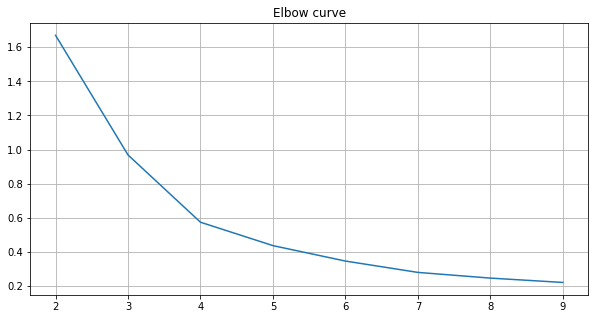

In [15]:
# get optimal k clusters
distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [16]:
# apply KMeans clustering to the keywords data with K=4
centers, clusters = clustering_keywordvecs(X, 4)

In [17]:
# assign list keywords of each cluster to variables
keywords_cluster_0 = list()
keywords_cluster_1 = list()
keywords_cluster_2 = list()
keywords_cluster_3 = list()
for index, keyword_vector in enumerate(keywords_in_vocab):
    try:
        #print(str(clusters[index])+":"+str(keyword_vector))
        print (str(clusters[index]))
        if clusters[index] ==0:
            keywords_cluster_0.extend(keyword_vector)
        elif clusters[index] ==1:
            keywords_cluster_1.extend(keyword_vector)
        elif clusters[index] ==2:
            keywords_cluster_2.extend(keyword_vector)
        else:
            keywords_cluster_3.extend(keyword_vector)       
    except IndexError:
        pass

0
0
1
0
1
1
2
2
2
2
0
0
1
1
1
0
1
0
2
1
2
1
0
2
1
0
3
1
0
0
2
1
0
1
2
2
2
1
1
3
0
0
1
0
3
2
1
2
1
1
3
3
1
1
3
2
2
2
2
2
2
3
1
1
1
2
2
2
0
2
1
0
0
0
1
1
2
2
1
0
0
1
1
0
2
1
3
0
3
0
1
0
0
1
1
3
0
0
1
1
1
1
0
1
0
1
1
1
0
0
1
0
0
3
1
1
0
1
0
1
1
1
1
2
1
2
1
0
1
1
1
1
0
0
2
0
1
1
1
1
2
2
3
1
0
1
1
2
0
1
0
3
0
1
0
1
1
1
1
1
0
1
2
1
1
0
3
3
0
2
3
3
0
0
1
1
3
0
3
2
2
1
1
1
3
1
1
0
1
1
1
2
0
0
0
3
1
0
1
3
3
1
2
0
1
0
0
1
0
0
2
2
1
1
2
2
2
0
2
1
1
3
1


### 3.5 Visualize Clustering Result

In [18]:
# Visualize based on frequent words in each cluster
def display_cloud_frequent(cluster_num, cmap):
    wc = WordCloud(background_color="white", max_words=2000, max_font_size=80, colormap=cmap)
    if cluster_num == 1:
        wordcloud = wc.generate(' '.join(keywords_cluster_0))
    elif cluster_num == 2:
        wordcloud = wc.generate(' '.join(keywords_cluster_1))
    elif cluster_num == 3:
        wordcloud = wc.generate(' '.join(keywords_cluster_2))
    elif cluster_num == 4:
        wordcloud = wc.generate(' '.join(keywords_cluster_3))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_frequent_' + str(cluster_num), bbox_inches='tight')

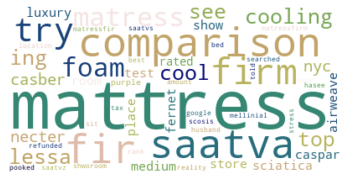

In [19]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for i in range(4):
    col = next(cmaps)
    display_cloud_frequent(i+1, col)

### Visualize cluster based on frequent words
![cluster 1](./cluster_frequent_1.png)
![cluster 2](./cluster_frequent_2.png)
![cluster 3](./cluster_frequent_3.png)
![cluster 4](./cluster_frequent_4.png)

### 3. 6 Keyword Analysis

In [22]:
# read updated KW Clusters excel file
# added one new column 'clusters' after aboved experiment
df = pd.read_excel('kw_clusters_update.xlsx', sheetname='All')
df

,id,cluster,keywords,total_sale,total_orders,total_coupons,type,created_at,updated_at,deleted_at
0,0,0,nectar website | nectar mattress store | nec...,57442.64,53,235,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
1,1,0,nectar website | bb website | brooklyn beddi...,70065.66,38,213,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
2,2,1,friend | friend referred | friend s | friend...,88063.04,54,229,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
3,3,0,leesa mattress | googled leesa | leesa and ...,11905.40,13,96,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
4,4,1,"yelp | yelp , and then visited your new york ...",25352.64,18,85,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
5,5,1,mattress stores | mattress stores nyc | bb s...,35029.99,18,113,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
6,6,2,mom group long island city | my mom | mom f...,3532.51,3,6,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
7,7,2,mom group long island city | facebook group ...,2932.84,2,4,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
8,8,2,mom group long island city,1649.20,1,0,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN
9,9,2,mom group long island city,1649.20,1,0,NaN,11/25/2019 0:00,11/25/2019 0:00,NaN


cluster
1               674981.28
0               555218.82
2               221958.62
not in vocab    107749.96
3                39172.52
Name: total_sale, dtype: float64


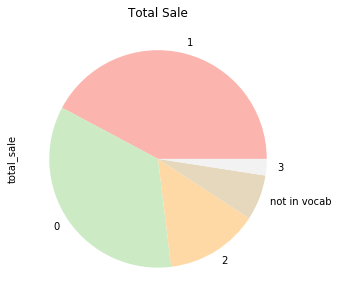

In [23]:
# total_sale based on cluster
print(df.groupby(['cluster'])['total_sale'].sum().sort_values(ascending=False))
df.groupby(['cluster'])['total_sale'].sum().sort_values(ascending=False).plot(kind='pie', figsize=(5,5), title='Total Sale', colormap='Pastel1')

cluster
1               437
0               393
2               144
not in vocab     79
3                30
Name: total_orders, dtype: int64


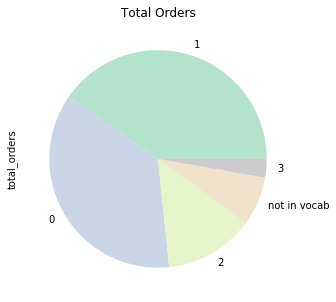

In [24]:
# total_orders based on cluster
print(df.groupby(['cluster'])['total_orders'].sum().sort_values(ascending=False))
df.groupby(['cluster'])['total_orders'].sum().sort_values(ascending=False).plot(kind='pie', figsize=(5,5), title='Total Orders', colormap='Pastel2')

cluster
1               1694
0               1300
2                308
3                 65
not in vocab      63
Name: total_coupons, dtype: int64


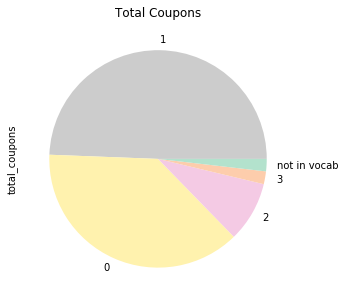

In [25]:
# total_coupons based on cluster
print(df.groupby(['cluster'])['total_coupons'].sum().sort_values(ascending=False))
df.groupby(['cluster'])['total_coupons'].sum().sort_values(ascending=False).plot(kind='pie',figsize=(5,5),title='Total Coupons', colormap='Pastel2_r')